--- France Game Score Summary ---
                            Label   Mean   N  CI_95_low  CI_95_high
5                         kimi-k2  30.40  20  28.484872   32.315128
3  gemini-2.5-flash-preview-05-20  26.85  20  25.083852   28.616148
0        Qwen3-235B-A22B-Instruct  26.20  20  24.923424   27.476576
7                llama-4-maverick  24.90  20  23.242365   26.557635
6          llama-3.3-70b-instruct  24.85  20  23.310137   26.389863
1   Qwen3-235B-A22B-Instruct-2507  23.65  20  22.284092   25.015908
4                    gpt-4.1-nano  21.55  20  20.529818   22.570182
2          devstral-small-1.1-24b  20.65  20  19.854797   21.445203
8  mistral-small-3.2-24b-instruct  20.15  20  19.525724   20.774276
---------------------------------


/tmp/ipykernel_32043/519544605.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


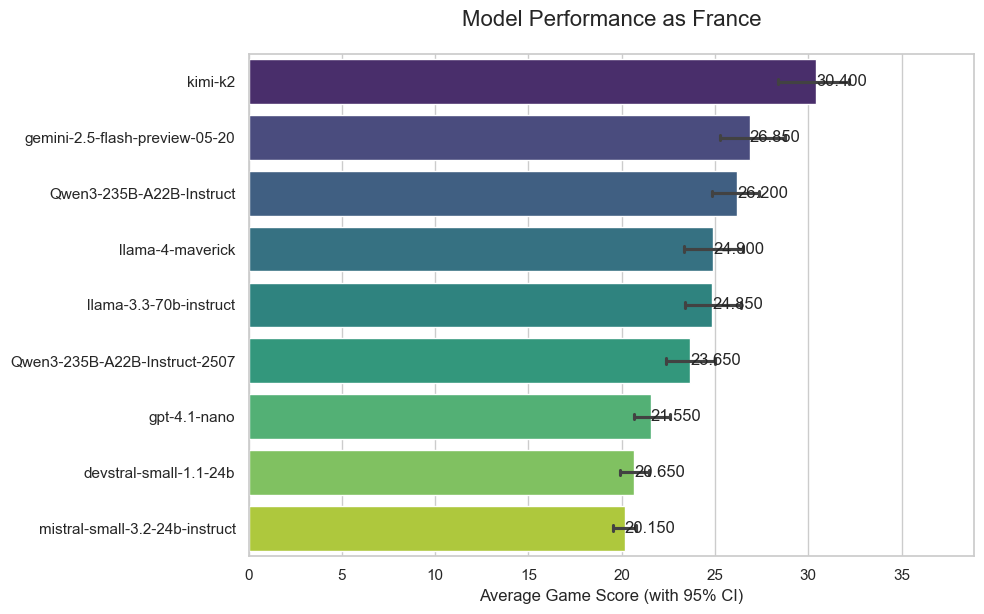

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# EDIT THE LIST BELOW: absolute or relative paths to your experiment folders
# Each folder should contain analysis/statistical_game_analysis/individual/*
# ---------------------------------------------------------------------------
exp_dirs = {
    "../data/sam-exp080-bench": "kimi-k2",
    "../data/sam-exp081-bench": "mistral-small-3.2-24b-instruct",
    "../data/sam-exp082-bench": "devstral-small-1.1-24b",
    "../data/sam-exp083-bench": "gemini-2.5-flash-preview-05-20",
    "../data/sam-exp090-bench": "Qwen3-235B-A22B-Instruct",
    "../data/sam-exp091-bench": "llama-4-maverick",
    "../data/sam-exp092-bench": "gpt-4.1-nano",
    #"../data/sam-exp105-bench": "glm-4.1v-9b-thinking",
    "../data/sam-exp106-bench": "llama-3.3-70b-instruct",
    "../data/sam-exp108-bench": "Qwen3-235B-A22B-Instruct-2507",
}

# ---------------------------------------------------------------------------
# Collect all individual France game_score values into a long-form DataFrame
# This format is ideal for Seaborn.
# ---------------------------------------------------------------------------
records = []
for exp_dir, label in exp_dirs.items():
    exp_path = Path(exp_dir).expanduser().resolve()
    csv_dir = exp_path / "analysis" / "statistical_game_analysis" / "individual"
    
    if not csv_dir.exists():
        print(f"warning: directory not found, skipping: {csv_dir}")
        continue
        
    csv_files = sorted(csv_dir.glob("run_*_game_analysis.csv"))
    
    num_scores_found = 0
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            france_rows = df[df["power_name"] == "FRANCE"]
            if not france_rows.empty and "game_score" in france_rows.columns:
                score = float(france_rows.iloc[0]["game_score"])
                records.append({"Label": label, "Score": score})
                num_scores_found += 1
        except Exception as exc:
            print(f"warning: could not process {csv_file} – {exc}")
            
    if num_scores_found == 0:
        print(f"no France scores found for {label} in {exp_path}")

# ---------------------------------------------------------------------------
# Build the main DataFrame from the collected records
# ---------------------------------------------------------------------------
if not records:
    raise RuntimeError("No data collected – check the paths and directory structure.")

all_scores_df = pd.DataFrame(records)

# ---------------------------------------------------------------------------
# Optional: Create a summary table for display, similar to the original
# We can do this easily from the long-form DataFrame.
# ---------------------------------------------------------------------------
# The `sem` function for standard error of the mean
def sem(x):
    return np.std(x, ddof=1) / np.sqrt(np.size(x))

summary_df = all_scores_df.groupby('Label')['Score'].agg(['mean', sem, 'count']).reset_index()
summary_df = summary_df.rename(columns={'mean': 'Mean', 'sem': 'SEM', 'count': 'N'})
# Calculate 95% CI from the aggregated data
summary_df['CI_95_low'] = summary_df['Mean'] - 1.96 * summary_df['SEM']
summary_df['CI_95_high'] = summary_df['Mean'] + 1.96 * summary_df['SEM']

print("--- France Game Score Summary ---")
print(summary_df[['Label', 'Mean', 'N', 'CI_95_low', 'CI_95_high']].sort_values('Mean', ascending=False))
print("-" * 33)

# ---------------------------------------------------------------------------
# Plot horizontal bar chart with Seaborn for a nicer look
# ---------------------------------------------------------------------------
# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Determine the order of bars by sorting the labels based on their mean score
order = all_scores_df.groupby('Label')['Score'].mean().sort_values(ascending=False).index

# Create the figure and axes
plt.figure(figsize=(10, max(3, 0.7 * len(exp_dirs))))

# Create the bar plot
# Seaborn automatically calculates the mean (for bar length) and 95% CI (for error bars)
ax = sns.barplot(
    data=all_scores_df,
    x="Score",
    y="Label",
    order=order,  # Use the sorted order
    palette="viridis", # A nice color palette
    errorbar=("ci", 95), # Explicitly request 95% CI
    capsize=0.1, # Add caps to the error bars
)

# Improve the plot's labels and title
ax.set_title("Model Performance as France", fontsize=16, pad=20)
ax.set_xlabel("Average Game Score (with 95% CI)", fontsize=12)
ax.set_ylabel("") # The labels on the y-axis are self-explanatory

# Add the mean value as a label on each bar for clarity
for i, bar in enumerate(ax.patches):
    # Get the mean value from our summary dataframe
    label = ax.get_yticklabels()[i].get_text()
    mean_val = summary_df.loc[summary_df['Label'] == label, 'Mean'].iloc[0]
    
    # Position the text
    ax.text(
        bar.get_width() + 0.01, # Position text slightly to the right of the bar
        bar.get_y() + bar.get_height() / 2, # Center vertically on the bar
        f'{mean_val:.3f}', # Format the number
        va='center', 
        ha='left'
    )

# Adjust x-axis limits to make space for the text labels
plt.xlim(right=plt.xlim()[1] * 1.15)

plt.tight_layout()
plt.show()